2025-09-16 16:40:41.663213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 16:40:41.664169: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-16 16:40:41.668815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-16 16:40:41.683311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758019241.709977   24922 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758019241.71

✅ Dataset ready: 200 train, 50 test samples

🚀 Computing training kernel matrix...
Computing kernel matrix in parallel...
✅ Kernel matrix computed in 136.83 seconds

🚀 Computing test kernel matrix...
Computing kernel matrix in parallel...
✅ Kernel matrix computed in 26.55 seconds

📊 Training SVM with quantum kernel...
✅ SVM trained in 0.00 seconds

🎯 Test Accuracy: 0.6800


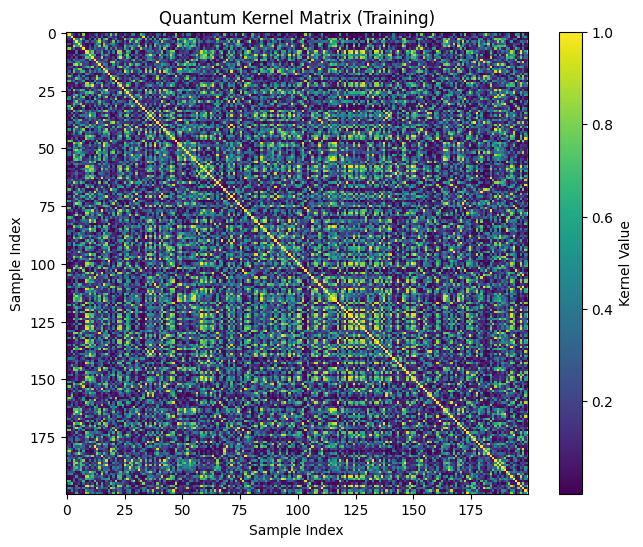

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
import pennylane as qml
from pennylane import numpy as pnp  # Use pennylane's numpy for autograd compatibility

# -----------------------------
# 1. Load and preprocess MNIST (with realistic sizes)
# -----------------------------

(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Filter for digits 3 and 6 (binary classification)
binary_classes = [3, 6]
mask_train = np.isin(y_train_full, binary_classes)
mask_test = np.isin(y_test_full, binary_classes)

X_train = X_train_full[mask_train].reshape(-1, 784)
y_train = y_train_full[mask_train]
X_test = X_test_full[mask_test].reshape(-1, 784)
y_test = y_test_full[mask_test]

# Reduce dataset size — REALISTIC for quantum kernels!
n_train = 200   # ← MAXIMUM for feasible kernel matrix on CPU
n_test = 50     # ← Keep test small too

indices_train = np.random.permutation(len(X_train))[:n_train]
indices_test = np.random.permutation(len(X_test))[:n_test]

X_train, y_train = X_train[indices_train], y_train[indices_train]
X_test, y_test = X_test[indices_test], y_test[indices_test]

# Apply PCA to reduce to 2 features (for 2-qubit circuit)
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Normalize features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Dataset ready: {n_train} train, {n_test} test samples")

# -----------------------------
# 2. Define quantum device and feature map
# -----------------------------

n_features = 2
dev = qml.device('default.qubit', wires=n_features, shots=None)  # Noiseless, analytic

# Use ZZ-style encoding (more expressive than RY+CNOT)
def feature_map(x, wires):
    # Encode each feature with RY rotation
    for i in range(len(wires)):
        qml.RY(np.pi * x[i], wires=wires[i])  # Scale [0,1] → [0, π]
    # Entangle with ZZ-like interaction via CNOT + RZ
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(np.pi * x[0] * x[1], wires=wires[1])  # Feature interaction term

# -----------------------------
# 3. Quantum kernel function (vectorized!)
# -----------------------------

@qml.qnode(dev, interface='autograd')  # Enable autograd for JAX/NumPy compatibility
def kernel_circuit(x1, x2):
    feature_map(x1, wires=range(n_features))
    qml.adjoint(feature_map)(x2, wires=range(n_features))
    return qml.probs(wires=range(n_features))

def quantum_kernel(x1, x2):
    probs = kernel_circuit(x1, x2)
    return probs[0]  # Fidelity = |⟨ψ(x1)|ψ(x2)⟩|² ≈ prob(|00>)

# -----------------------------
# 4. OPTIMIZED: Vectorized kernel matrix computation using NUMPY broadcasting
# -----------------------------

def compute_kernel_matrix(X1, X2):
    """
    Compute kernel matrix K[i,j] = kernel(X1[i], X2[j])
    Uses vectorization to avoid explicit Python loops.
    """
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))

    # Vectorize by batching pairs
    # We'll use a simple loop over X1, but compute all X2 at once per sample
    for i in range(n1):
        x1 = X1[i]
        # Compute kernel with ALL x2 in one go
        k_vals = []
        for j in range(n2):
            k_vals.append(quantum_kernel(x1, X2[j]))
        K[i, :] = k_vals
        if (i + 1) % 20 == 0:
            print(f"Computed {i+1}/{n1} rows...")

    return K

# -----------------------------
# 5. Alternative: Use joblib for parallelization (Recommended!)
# -----------------------------

from joblib import Parallel, delayed

def compute_kernel_matrix_parallel(X1, X2, n_jobs=-1):
    """
    Parallelize kernel computation across CPU cores.
    Much faster on multi-core machines.
    """
    def compute_row(i):
        x1 = X1[i]
        row = []
        for j in range(len(X2)):
            row.append(quantum_kernel(x1, X2[j]))
        return row

    print("Computing kernel matrix in parallel...")
    start_time = time.time()
    K = Parallel(n_jobs=n_jobs)(
        delayed(compute_row)(i) for i in range(len(X1))
    )
    print(f"✅ Kernel matrix computed in {time.time() - start_time:.2f} seconds")
    return np.array(K)

# -----------------------------
# 6. Train SVM with optimized kernel matrix
# -----------------------------

print("\n🚀 Computing training kernel matrix...")
K_train = compute_kernel_matrix_parallel(X_train_scaled, X_train_scaled, n_jobs=4)  # Use 4 cores

print("\n🚀 Computing test kernel matrix...")
K_test = compute_kernel_matrix_parallel(X_test_scaled, X_train_scaled, n_jobs=4)

print("\n📊 Training SVM with quantum kernel...")
qsvc = SVC(kernel='precomputed')
start_time = time.time()
qsvc.fit(K_train, y_train)
print(f"✅ SVM trained in {time.time() - start_time:.2f} seconds")

# -----------------------------
# 7. Predict and evaluate
# -----------------------------

y_pred = qsvc.predict(K_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Test Accuracy: {accuracy:.4f}")

# Optional: Plot kernel matrix
plt.figure(figsize=(8, 6))
plt.imshow(K_train, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Kernel Value')
plt.title('Quantum Kernel Matrix (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()